In [577]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [578]:
df = yf.download('BTC-USD',start='2025-01-01', end='2025-9-24', interval="1d")
df_future = yf.download('BTC-USD',start='2025-9-25', end='2025-10-25', interval="1d")
df.sample(3)

C:\Users\davood\AppData\Local\Temp\ipykernel_8760\136167839.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD',start='2025-01-01', end='2025-9-24', interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\davood\AppData\Local\Temp\ipykernel_8760\136167839.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_future = yf.download('BTC-USD',start='2025-9-25', end='2025-10-25', interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2025-08-04,115071.882812,115729.468750,114130.406250,114223.921875,35783028986
2025-07-29,117922.148438,119273.867188,116987.367188,117938.585938,68463107433
2025-01-17,104462.039062,105884.226562,99948.906250,100025.765625,71888972663


In [579]:
df.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [580]:

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
if isinstance(df_future.columns, pd.MultiIndex):
    df_future.columns = df_future.columns.get_level_values(0)


In [581]:
df.columns.name = None
df_future.columns.name = None

In [582]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [583]:
df.describe()

,Close,High,Low,Open,Volume
count,266.000000,266.000000,266.000000,266.000000,2.660000e+02
mean,102012.877262,103487.248943,100312.723537,101941.928425,4.946377e+10
std,11648.364245,11458.673179,11888.176355,11645.197270,2.242467e+10
min,76271.953125,80823.890625,74436.679688,76273.562500,9.863214e+09
25%,94495.458984,95397.007812,92870.251953,94434.439453,3.411773e+10
50%,104052.464844,105664.652344,102357.652344,103980.195312,4.766710e+10
75%,111300.431641,112614.347656,110164.740234,111211.964844,6.160076e+10
max,123344.062500,124457.117188,118959.195312,123339.398438,1.817464e+11


In [584]:
df['predClose'] = df['Close'].shift(-1)
df_future['predClose'] = df_future['Close'].shift(-1)

In [585]:
dfs = [df, df_future]
for data in dfs:
    data['change'] = data['Close'] - data['Open']
    data['pct_change'] = data['Close'].pct_change()
    data['MA5'] = data['Close'].rolling(5).mean()
    data['Vol_MA5'] = data['Volume'].rolling(5).mean()
    data['Volatility'] = data['Close'].rolling(5).std()
    data['HL_diff'] = data['High'] - data['Low']
    data['OC_diff'] = data['Open'] - data['Close']


In [586]:
df = df[5:-1]
df_future = df_future[5:-1] 

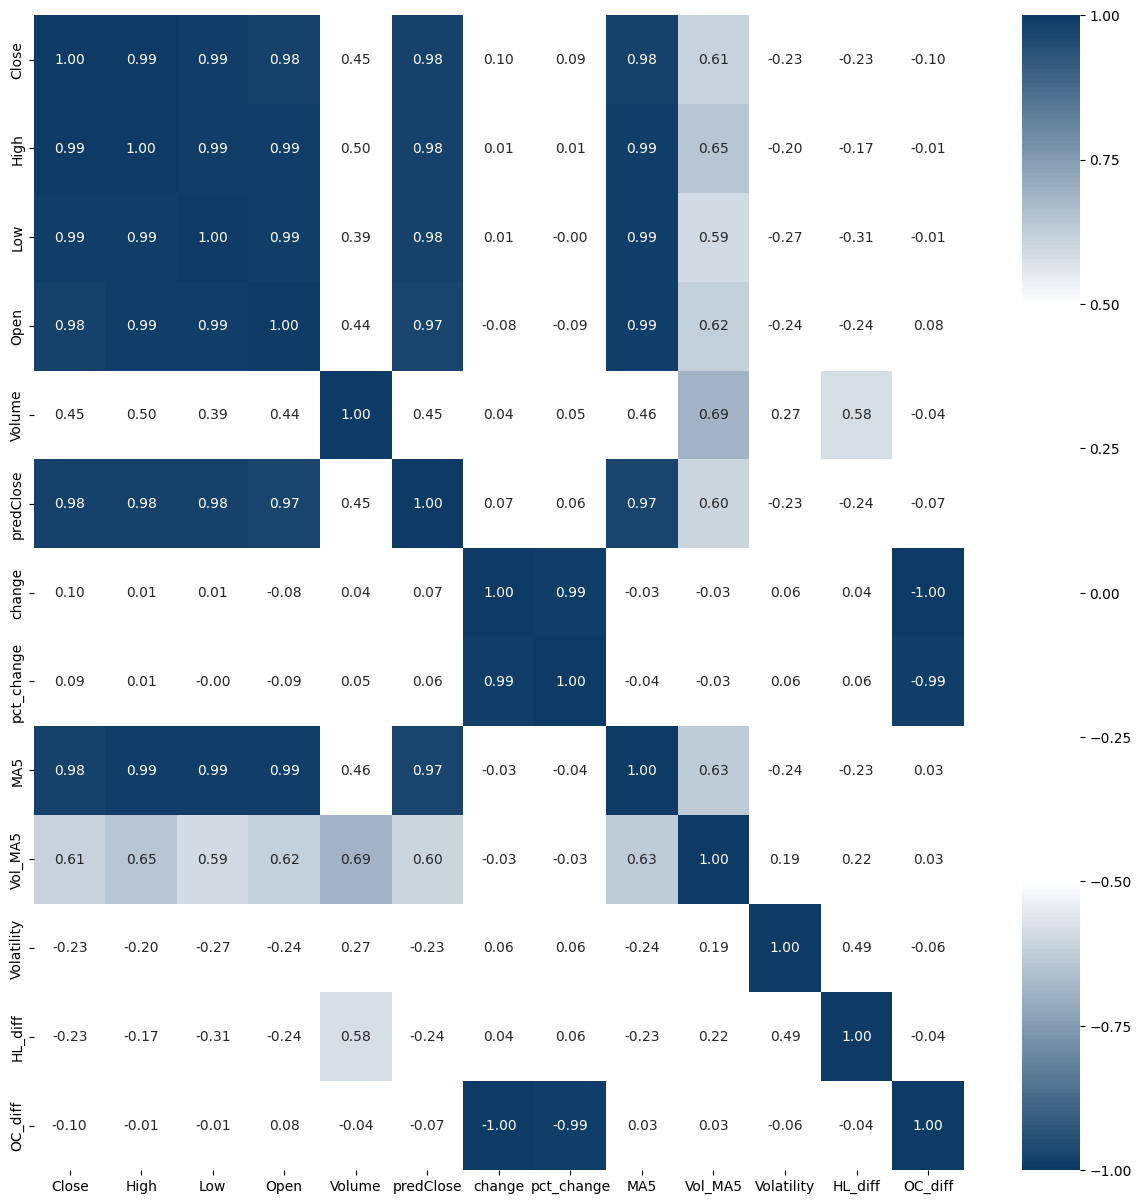

Close      High          0.992962
           Low           0.991530
           Open          0.983698
           predClose     0.983909
           MA5           0.984051
High       Low           0.988708
           Open          0.991794
           predClose     0.978981
           MA5           0.988287
Low        Open          0.991541
           predClose     0.979366
           MA5           0.986432
Open       predClose     0.971852
           MA5           0.991092
predClose  MA5           0.971675
change     pct_change    0.992020
dtype: float64


,feature1,feature2,corr,targetCorrWithF1,targetCorrWithF2
0,Close,High,0.992962,0.983909,0.978981
1,change,pct_change,0.992020,0.073837,0.064041
2,High,Open,0.991794,0.978981,0.971852
3,Low,Open,0.991541,0.979366,0.971852
4,Close,Low,0.991530,0.983909,0.979366
5,Open,MA5,0.991092,0.971852,0.971675
6,High,Low,0.988708,0.978981,0.979366
7,High,MA5,0.988287,0.978981,0.971675
8,Low,MA5,0.986432,0.979366,0.971675
9,Close,MA5,0.984051,0.983909,0.971675


In [587]:
corr_matrix = df.corr()
colors = [
    (0.0, "#0D3B66"),
    (0.25, "white"),
    (0.75, "white"),
    (1.0, "#0D3B66")
]
cmap = LinearSegmentedColormap.from_list('', colors)
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, vmax=1, vmin=-1)
plt.show()
corr_matrix_filtered = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k =1).astype('bool'))
corr_matrix_filtered = corr_matrix_filtered[corr_matrix_filtered>0.8].stack()
print(corr_matrix_filtered)
corr_matrix_filtered = corr_matrix_filtered.reset_index().rename(columns={'level_0':'feature1', 'level_1':'feature2', 0:'corr'})
corr_matrix_filtered = corr_matrix_filtered.sort_values(by='corr',ascending=False)

f1 = []
f2 = []
for feature1 in corr_matrix_filtered['feature1']:
   f1.append(df[feature1].corr(df['predClose']))
for feature2 in corr_matrix_filtered['feature2']:
  f2.append(df[feature2].corr(df['predClose']))
corr_matrix_filtered['targetCorrWithF1'] = f1
corr_matrix_filtered['targetCorrWithF2'] = f2
corr_matrix_filtered.reset_index(drop=True, inplace=True)
corr_matrix_filtered

In [588]:
df.drop(['High','pct_change','Low', 'MA5', 'Open'], axis=1, inplace=True)
df_future.drop(['High','pct_change','Low', 'MA5', 'Open'], axis=1, inplace=True)

C:\Users\davood\AppData\Local\Temp\ipykernel_8760\3610100520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['High','pct_change','Low', 'MA5', 'Open'], axis=1, inplace=True)
C:\Users\davood\AppData\Local\Temp\ipykernel_8760\3610100520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_future.drop(['High','pct_change','Low', 'MA5', 'Open'], axis=1, inplace=True)


In [589]:
df.sample(1)

,Close,Volume,predClose,change,Vol_MA5,Volatility,HL_diff,OC_diff
Date,,,,,,,,
2025-07-06,109232.070312,36746020463,108299.851562,1000.882812,4.334428e+10,674.362874,1884.609375,-1000.882812


In [590]:
X = df.drop(['predClose'], axis=1)
y = df['predClose']
X_future = df_future.drop(['predClose'], axis=1)
y_future = df_future['predClose']

In [591]:
X

,Close,Volume,change,Vol_MA5,Volatility,HL_diff,OC_diff
Date,,,,,,,
2025-01-06,102078.085938,51823432705,3763.132812,3.526245e+10,1962.798577,4556.726562,-3763.132812
2025-01-07,96922.703125,58685738547,-5326.148438,3.779769e+10,1954.459463,6579.609375,5326.148438
2025-01-08,95043.523438,63875859171,-1880.640625,4.345058e+10,2579.543878,4732.476562,1880.640625
2025-01-09,92484.039062,62777261693,-2559.445312,5.153751e+10,3596.486042,4128.875000,2559.445312
2025-01-10,94701.453125,62058693684,2206.960938,5.984420e+10,3621.293917,3520.515625,-2206.960938
...,...,...,...,...,...,...,...
2025-09-18,117137.203125,49457272032,675.937500,4.830059e+10,797.493999,1722.992188,-675.937500
2025-09-19,115688.859375,38828473971,-1448.812500,4.950668e+10,729.335761,2337.937500,1448.812500
2025-09-20,115721.960938,22864449614,30.835938,4.349199e+10,653.088647,717.625000,-30.835938


In [592]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

scoring = ['r2', 'neg_root_mean_squared_error']
evaluation_df = pd.DataFrame(np.zeros((1,4)), columns=['test_r2', 'test_RMSE','train_r2', 'train_RMSE'], index=['linear'])
tss = TimeSeriesSplit(n_splits=5)
cross_validation = cross_validate(pipeline, X, y, cv=tss, scoring=scoring, return_train_score=True)
evaluation_df.iloc[:,:] =[cross_validation['test_r2'].mean(), -cross_validation['test_neg_root_mean_squared_error'].mean(),
                          cross_validation['train_r2'].mean(), -cross_validation['train_neg_root_mean_squared_error'].mean()
                          ]
evaluation_df

,test_r2,test_RMSE,train_r2,train_RMSE
linear,0.604621,2236.290771,0.896551,2128.936288


In [593]:
pipeline.fit(X, y)  
y_future_pred = pipeline.predict(X_future)

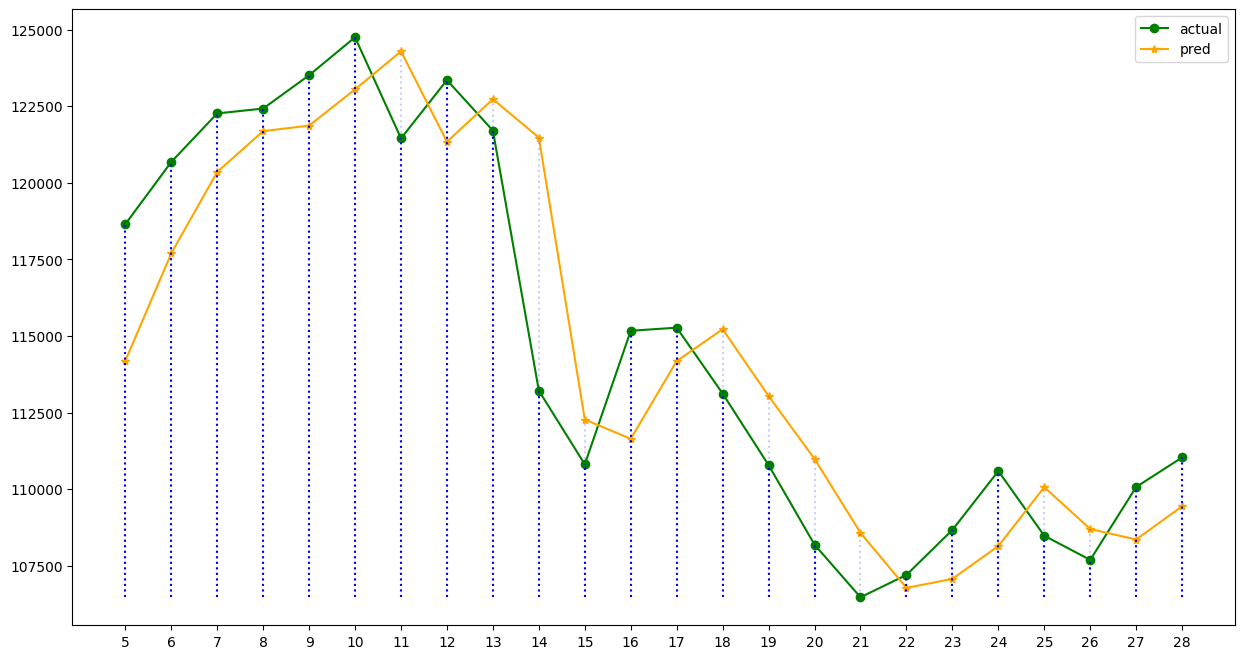

In [594]:
y_min = min(y_future.min(), y_future_pred.min())
a= np.arange(5,len(df_future)+5,1)
plt.figure(figsize=(15,8))
plt.plot(a, y_future, marker='o', color = 'green', label = 'actual')
plt.plot(a, y_future_pred, marker='*', color = 'orange', label = 'pred')
plt.vlines(a,y_min, y_future, colors='blue', linestyles='dotted', alpha=1)
plt.vlines(a,y_min, y_future_pred, colors='blue', linestyles='dotted', alpha=0.2)
plt.xticks(a)
plt.legend()
plt.show()

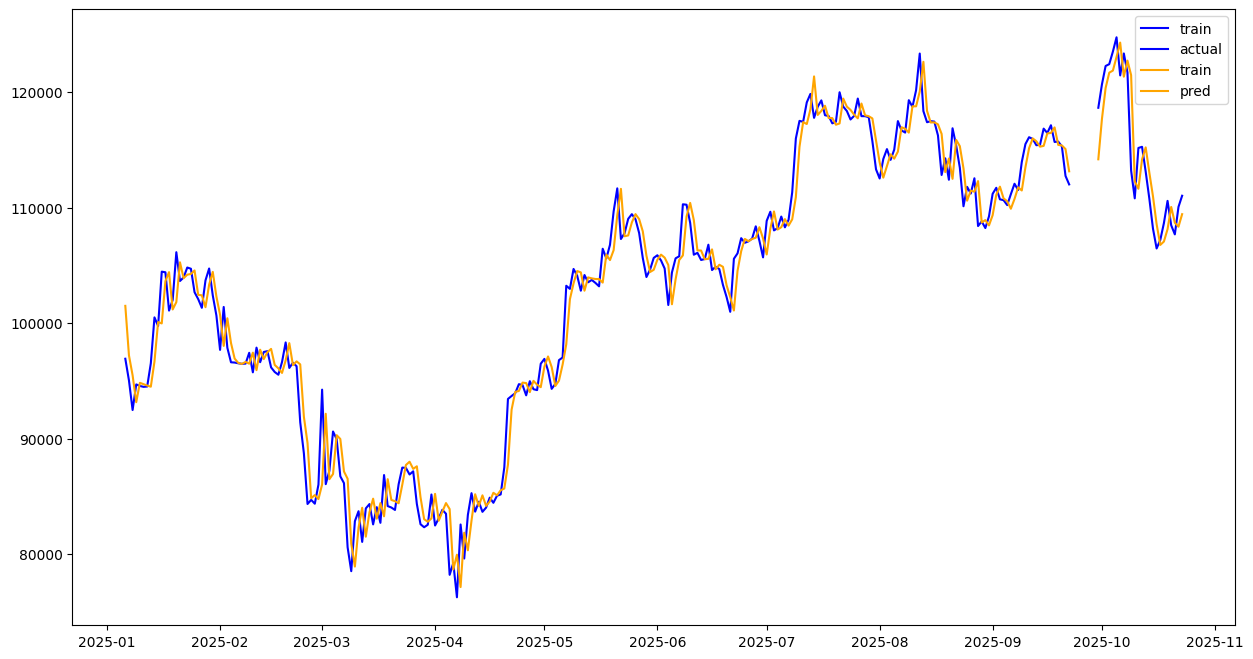

In [595]:
y_pred = pipeline.predict(X)
y_min = min(y_future.min(), y_future_pred.min(),y.min())
y_future_pred = pd.Series(y_future_pred, index=y_future.index)
y_pred = pd.Series(y_pred, index=y.index)
plt.figure(figsize=(15,8))
plt.plot(y, color = 'blue', label = 'train')
plt.plot(y_future, color = 'blue', label = 'actual')
plt.plot(y_pred, color = 'orange', label = 'train')
plt.plot(y_future_pred, color = 'orange', label = 'pred')
plt.legend()
plt.show()



نتیجه گیری:
مدل عملکرد خیلی خوبی ندارد اما با توجه به کم بودن داده و فیچرهایی که بیشتر مربوط به روز جاری هستند و خطی بودن مدل برای چنین داده ای که بسیار نوسان دارد . معقول است.
